# Ironhack Final Project

The dataset used for this project was taken out of the following URL: 
https://www.kaggle.com/sakshigoyal7/credit-card-customers

This final project is mainly focused in predicting the Attrition rate aka Churn, is a measure of the number of individuals or items moving out of a collective group over a specific period. It is one of two primary factors that determine the steady-state level of customers a business will support.

In this specific case we will be looking a Data Set of "X" Bank, and their customers, trying to predict if X or Y customer will close their account. In order to do that, we will explore the data (ETL), do some basic cleaning, and use 5 different ML models to make the Churn predictions.

In [1]:
# IMPORT LIBRARIES
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly_express as px

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv('credit_attrition.csv')

In [3]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [4]:
# Check for missing values in the df
df.isna().sum()

CLIENTNUM                                                                                                                             0
Attrition_Flag                                                                                                                        0
Customer_Age                                                                                                                          0
Gender                                                                                                                                0
Dependent_count                                                                                                                       0
Education_Level                                                                                                                       0
Marital_Status                                                                                                                        0
Income_Category                                 

In [5]:
# Check unique values in the Attrition Flag column, to make sure we only have 2 values, we want a binary classification
# problem
df['Attrition_Flag'].unique()

array(['Existing Customer', 'Attrited Customer'], dtype=object)

In [6]:
# Now I want to know the unique values of every categorical column in the df
# First I want to match the column name to the lenght of unique values inside that column
print({column: len(df[column].unique()) for column in df.select_dtypes('object').columns})



{'Attrition_Flag': 2, 'Gender': 2, 'Education_Level': 7, 'Marital_Status': 4, 'Income_Category': 6, 'Card_Category': 4}


In [7]:
# Now I want to get the list of unique values inside every column
{column: list(df[column].unique()) for column in df.select_dtypes('object').columns}

{'Attrition_Flag': ['Existing Customer', 'Attrited Customer'],
 'Gender': ['M', 'F'],
 'Education_Level': ['High School',
  'Graduate',
  'Uneducated',
  'Unknown',
  'College',
  'Post-Graduate',
  'Doctorate'],
 'Marital_Status': ['Married', 'Single', 'Unknown', 'Divorced'],
 'Income_Category': ['$60K - $80K',
  'Less than $40K',
  '$80K - $120K',
  '$40K - $60K',
  '$120K +',
  'Unknown'],
 'Card_Category': ['Blue', 'Gold', 'Silver', 'Platinum']}

In [8]:
# We will use enconding in order to assign "values" to our categorical data columns

def binary_encoding(df, column, positive_value):
    df = df.copy()
    df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)
    return df

def ordinal_encoding(df, column, ordering):
    df = df.copy()
    df[column] = df[column].apply(lambda x: ordering.index(x))
    return df

def onehot_encoding(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [11]:
def processed_data(df):
    df = df.copy()
    
    # Drop last two columns like mentioned by the owner of the Dataset, columns are part of a different analysis
    # and we don't need them
    df = df.drop(df.columns[-2:], axis=1)
    
    # Drop clientum columns, these are all unique values
    df = df.drop('CLIENTNUM', axis=1)
    
    # Encode unknown values
    df = df.replace('Unknown', np.NaN)
    
    # Fill ordinal missing values
    df['Education_Level'] = df['Education_Level'].fillna('Graduate')
    df['Income_Category'] = df['Income_Category'].fillna('Less than $40K')
    
    # binary columns encoding
    df = binary_encoding(df, 'Attrition_Flag', positive_value='Attrited Customer')
    df = binary_encoding(df, 'Gender', positive_value='M')
    
    # Encode ordinal columns
    education_ordering = [
        'Uneducated',
        'High School',
        'College',
        'Graduate',
        'Post-Graduate',
        'Doctorate'
    ]
    income_ordering = [
        'Less than $40K',
        '$40K - $60K',
        '$60K - $80K',
        '$80K - $120K',
        '$120K +'
    ]
    df = ordinal_encoding(df, 'Education_Level', ordering=education_ordering)
    df = ordinal_encoding(df, 'Income_Category', ordering=income_ordering)
    
    # Encode nominal columns
    df = onehot_encoding(df, 'Marital_Status', prefix='St')
    df = onehot_encoding(df, 'Card_Category', prefix='Card')
    
    # Split df X & y
    y = df['Attrition_Flag'].copy()
    X = df.drop('Attrition_Flag', axis=1).copy()
    
    #  Standard Scaler X, this is going to give each column in X a mean 0 and a varience 1
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    return X, y

# We are returning X and Y as dataframes, y = what we want to predict, and X = what we use to predict, fully processed
# we are splitting them off from the beggining 
# Y is just the attrition flag column because like I mentioned that's what we are trying to predict
# X is everything else except the attrition flag 

In [12]:
X, y = processed_data(df)

In [13]:
X.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Income_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,St_Divorced,St_Married,St_Single,Card_Blue,Card_Gold,Card_Platinum,Card_Silver
0,-0.165406,1.059956,0.503368,-0.893680,0.597300,0.384621,0.763943,-1.327136,0.492404,0.446622,...,-0.973895,3.834003,-0.775882,-0.282405,1.077338,-0.798507,0.270611,-0.107644,-0.044484,-0.240794
1,0.333570,-0.943436,2.043199,0.593388,-0.887628,1.010715,1.407306,-1.327136,-0.411616,-0.041367,...,-1.357340,12.608573,-0.616276,-0.282405,-0.928214,1.252337,0.270611,-0.107644,-0.044484,-0.240794
2,0.583058,1.059956,0.503368,0.593388,1.339764,0.008965,0.120579,-1.327136,-2.219655,-0.573698,...,-1.911206,6.807864,-0.997155,-0.282405,1.077338,-0.798507,0.270611,-0.107644,-0.044484,-0.240794
3,-0.789126,-0.943436,1.273283,-0.893680,-0.887628,-0.241473,-0.522785,1.641478,-1.315636,-0.585251,...,-1.911206,6.807864,1.759686,-0.282405,-0.928214,-0.798507,0.270611,-0.107644,-0.044484,-0.240794
4,-0.789126,1.059956,0.503368,-1.637214,0.597300,-1.869317,0.763943,-1.327136,-2.219655,-0.430877,...,-1.570365,7.509325,-0.997155,-0.282405,1.077338,-0.798507,0.270611,-0.107644,-0.044484,-0.240794


In [14]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Attrition_Flag, dtype: int64

In [15]:
# Data is now ready to be fed into the model 

# Exploration of the data & Visualization

In [16]:
cat_df = pd.concat([X.loc[:, ['Customer_Age', 'Months_on_book']], X.loc[:,'Credit_Limit':'Avg_Utilization_Ratio']], axis=1).copy()

In [17]:
cat_df.head()

,Customer_Age,Months_on_book,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,-0.165406,0.384621,0.446622,-0.473422,0.488971,2.623494,-0.959707,-0.973895,3.834003,-0.775882
1,0.333570,1.010715,-0.041367,-0.366667,-0.008486,3.563293,-0.916433,-1.357340,12.608573,-0.616276
2,0.583058,0.008965,-0.573698,-1.426858,-0.445658,8.367214,-0.740982,-1.911206,6.807864,-0.997155
3,-0.789126,-0.241473,-0.585251,1.661686,-0.734100,2.942843,-0.951758,-1.911206,6.807864,1.759686
4,-0.789126,-1.869317,-0.430877,-1.426858,-0.302868,6.455682,-1.056263,-1.570365,7.509325,-0.997155


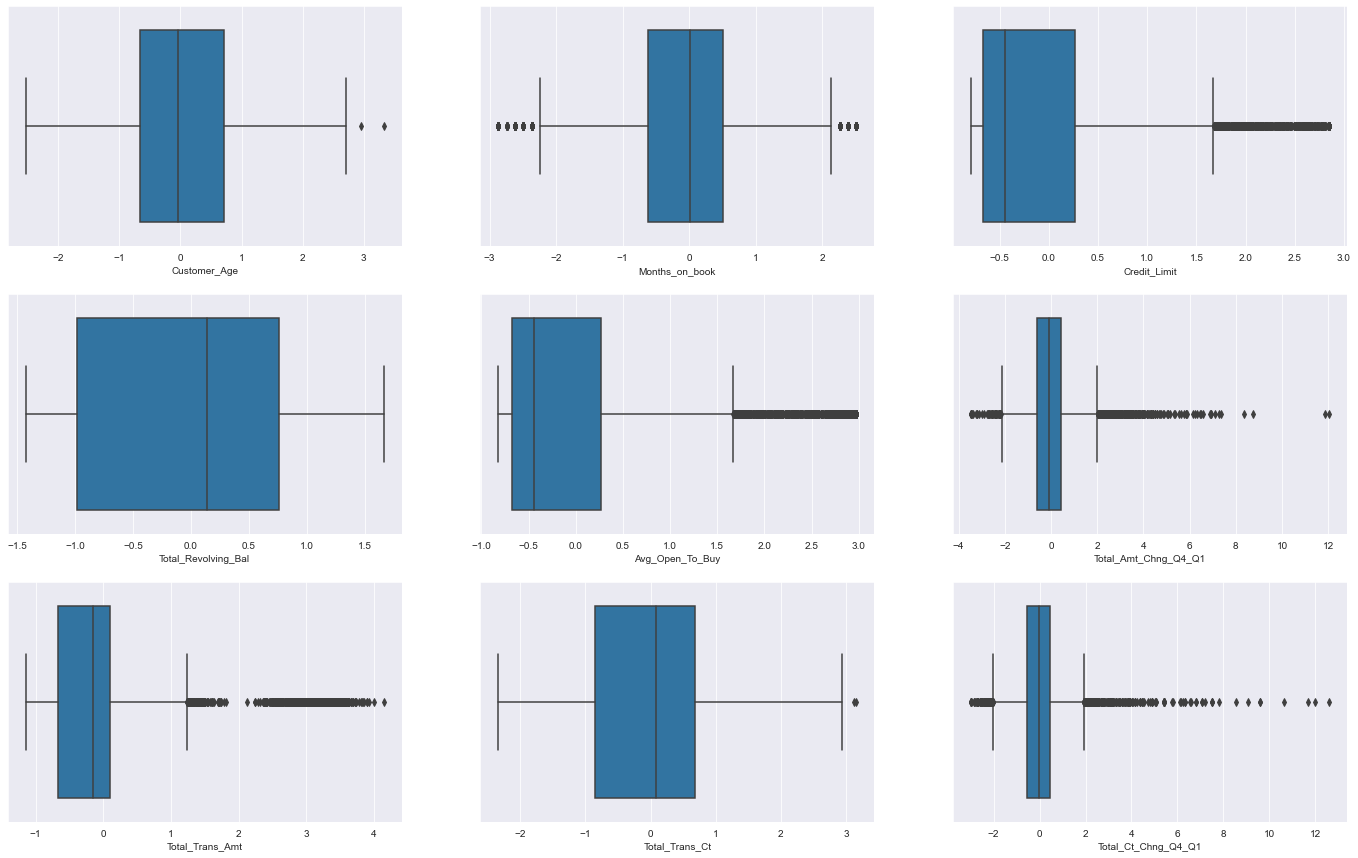

In [18]:
plt.figure(figsize=(24, 15))

for i in range (len(cat_df.columns)-1):
    plt.subplot(3,3,i+1)
    sns.boxplot(cat_df[cat_df.columns[i]])
    
plt.show()

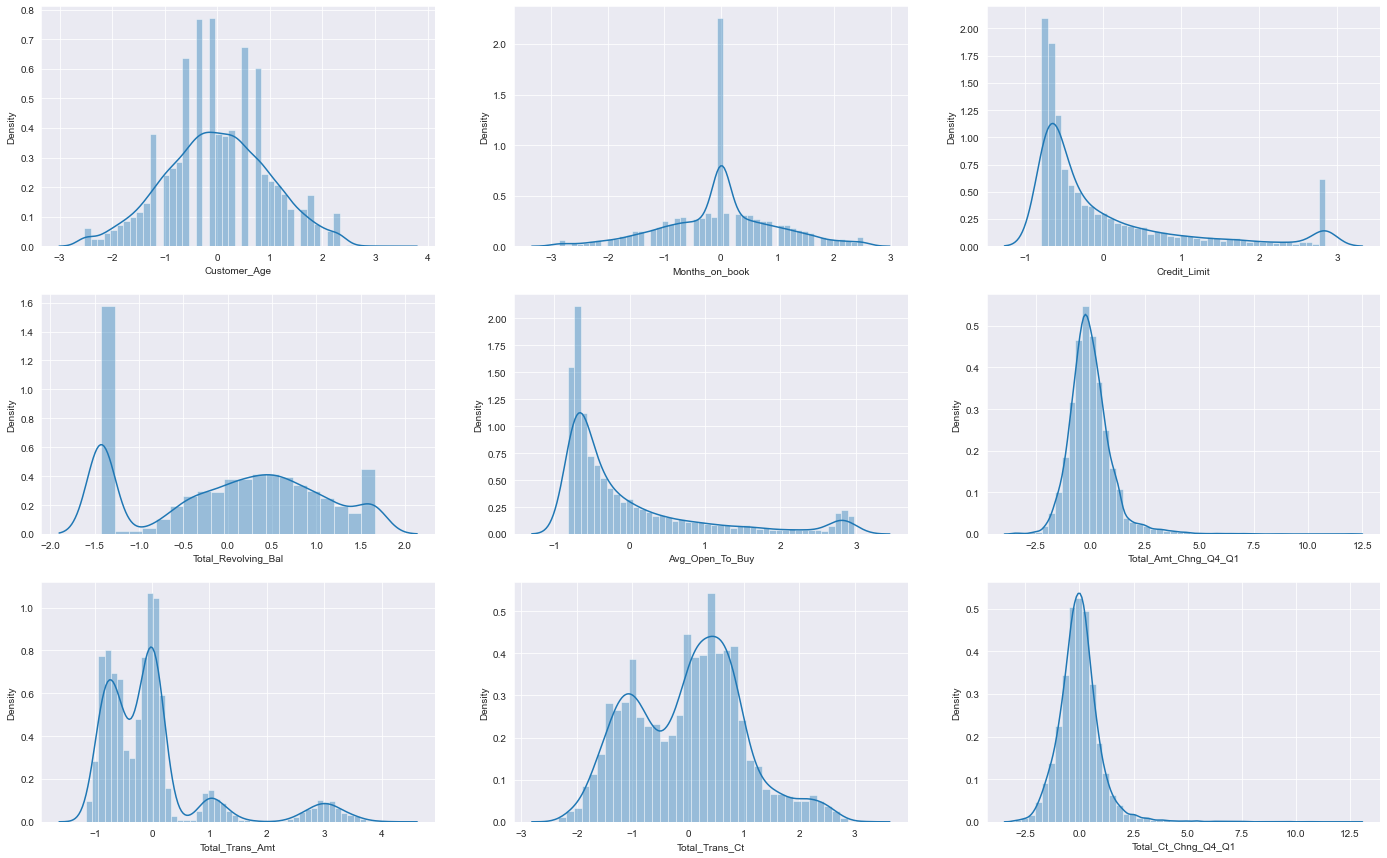

In [19]:
plt.figure(figsize=(24, 15))

for i in range(len(cat_df.columns) - 1):
    plt.subplot(3, 3, i + 1)
    sns.distplot(cat_df[cat_df.columns[i]])

plt.show()

In [ ]:
plt.figure(figsize=(20, 20))
sns.pairplot(cat_df)
plt.show()


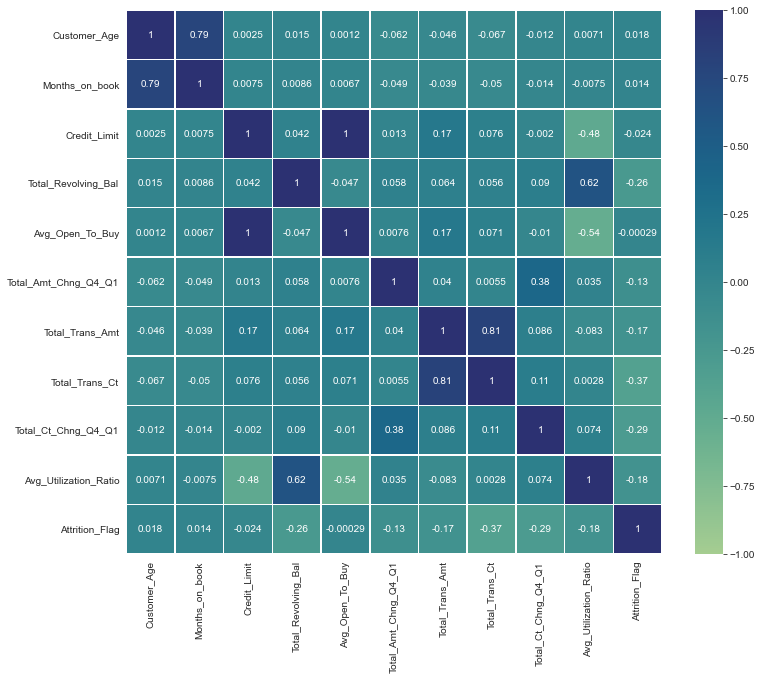

In [21]:
corr = pd.concat([cat_df, y], axis=1).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap='crest', linewidths=.5)
plt.show()

# Model selection, Training & Comparison 

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)

In [23]:
models = [
    LogisticRegression(),
    SVC(),
    DecisionTreeClassifier(),
    MLPClassifier(),
    RandomForestClassifier()
]

for model in models:
    model.fit(X_train, y_train)

In [24]:
model_names = [
    "   Logistic Regression",
    "Support Vector Machine",
    "         Decision Tree",
    "         Random Forest"
]

for model, name in zip(models, model_names):
    print(name + ": {:.4f}%".format(model.score(X_test, y_test) * 100))

   Logistic Regression: 90.4574%
Support Vector Machine: 92.9911%
         Decision Tree: 93.7150%
         Random Forest: 93.4189%
